In [13]:
import sys
from typing import Iterable
import warnings

import nibabel as nib
from nilearn import datasets, image, plotting
import numpy as np
import pandas as pd


import xml.etree.ElementTree as ET
import json
from neurolang.frontend import NeurolangPDL
from rdflib import RDFS

In [14]:
def parse_region(elem, id_2_num, father=None, triples=[]):
    name = elem['name']
    if 'labelIndex' in elem:
        if elem['labelIndex'] is not None:
            index = int(elem['labelIndex'])
            if index in id_2_num:
                num = id_2_num[index]
                triples.append((name, num))
        
    for c in elem['children']:
        parse_region(c, id_2_num, father=name, triples=triples)
        
    return triples

# Ontology
julich_ontology_l = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich_ontology'),
    [
        (
            'julich_ontology_l.xml',
            'https://raw.githubusercontent.com/NeuroLang/neurolang_data/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_l_N10_nlin2Stdicbm152asym2009c_publicDOI_3f6407380a69007a54f5e13f3c1ba2e6.xml',
            {'move': 'julich_ontology_l.xml'}
        )
    ]
)[0]

julich_ontology_r = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich_ontology'),
    [
        (
            'julich_ontology_r.xml',
            'https://raw.githubusercontent.com/NeuroLang/neurolang_data/main/Julich-Brain/WB/22/MPM/'
            'JulichBrain_MPMAtlas_l_N10_nlin2Stdicbm152asym2009c_publicDOI_3f6407380a69007a54f5e13f3c1ba2e6.xml',
            {'move': 'julich_ontology_r.xml'}
        )
    ]
)[0]

jubrain_ontology = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('julich_ontology'),
    [
        (
            'jubrain_ontology.xml',
            'https://raw.githubusercontent.com/NeuroLang/neurolang_data/main/Julich-Brain/WB/22/jubrain-ontology_22.json',
            {'move': 'jubrain_ontology.xml'}
        )
    ]
)[0]

tree = ET.parse(julich_ontology_l)

id_2_num = {}
for a in tree.iter():
    if a.tag == 'Structure':
        num = int(a.attrib['grayvalue'])
        id_ = int(a.attrib['id'])
        id_2_num[id_] = num

tree = ET.parse(julich_ontology_r)

for a in tree.iter():
    if a.tag == 'Structure':
        num = int(a.attrib['grayvalue'])
        id_ = int(a.attrib['id'])
        id_2_num[id_] = num


with open(jubrain_ontology) as f:
    data = json.load(f)

regions = data['properties']['regions']
for elem in regions:
    triples = parse_region(elem, id_2_num)
    
    #for n, r in [
    #    (13, 'GapMap Frontal-I (GapMap)'),
    #    (32, 'GapMap Frontal-to-Occipital (GapMap)'),
    #    (59, 'GapMap Temporal-to-Parietal (GapMap)'),
    #    (89, 'GapMap Frontal-II (GapMap)'),
    #    (95, 'GapMap Frontal-to-Temporal (GapMap)')
    #]:
    #    triples.append((r, n))
        
    f.close()   
    regions = pd.DataFrame(triples, columns=['r_name', 'r_number']).astype({'r_number': 'int32'}).sort_values('r_number')
    regions.drop_duplicates(inplace=True)
    
regions2 = regions.copy()
regions2['r_number'] = regions2['r_number'] + 1000
regions2['hemis'] = 'l'
regions['hemis'] = 'r'

regions = pd.concat((regions, regions2))

In [49]:
regions

,r_name,r_number,hemis
91,Area TE 1.1 (HESCHL),1,r
19,Area 3b (PostCG),2,r
48,Area hOc4la (LOC),3,r
23,Area PF (IPL),4,r
44,"Area hOc2 (V2, 18)",5,r
...,...,...,...
115,Area i29 (retrosplenial),1120,l
10,Area 7PC (SPL),1121,l
46,Area hOc4lp (LOC),1122,l
89,Area TeI (STG),1123,l


In [52]:
from scipy.stats import ttest_1samp, ttest_rel

res1 = {}

for id_region in regions.r_number.values:
    if id_region == 103:
        continue
    term = pd.read_hdf('neuro_paper_ri_term_probs_folds.hdf', key=f'region_{str(id_region)}')
    no_term = pd.read_hdf('neuro_paper_ri_no_term_probs_folds.hdf', key=f'region_{str(id_region)}')
    
    term = term.groupby('t').mean()[['PROB']]
    no_term = no_term.groupby('t').mean()[['PROB']]
    
    df = term.join(no_term, lsuffix=f'_term', rsuffix=f'_no_term')
    
    ttest = {}

    for k, v in df.iterrows():
        t = ttest_1samp([v.values[0], v.values[1]], popmean=0)
        ttest[k] = t
        
    res_reg = pd.DataFrame(ttest).T.rename(columns={0: 'statistic', 1: 'pvalue'})
    res1[id_region] = res_reg

In [48]:
from scipy.stats import ttest_1samp, ttest_rel

res1 = {}

for id_region in regions.r_number.values:
    if id_region == 103:
        continue
    term = pd.read_hdf('neuro_paper_ri_term_probs_folds.hdf', key=f'region_{str(id_region)}')
    no_term = pd.read_hdf('neuro_paper_ri_no_term_probs_folds.hdf', key=f'region_{str(id_region)}')
    
    term = term.groupby('t').mean()[['PROB']]
    no_term = no_term.groupby('t').mean()[['PROB']]
    
    df = term.join(no_term, lsuffix=f'_term', rsuffix=f'_no_term')
    
    ttest = {}

    for k, v in df.iterrows():
        t = ttest_1samp([v.values[0], v.values[1]], popmean=0)
        ttest[k] = t
        
    res_reg = pd.DataFrame(ttest).T.rename(columns={0: 'statistic', 1: 'pvalue'})
    res1[id_region] = res_reg

In [54]:
pd.read_hdf('neuro_paper_ri_term_results2.hdf', key=f'region_{str(1)}')

,t,act_mean,act_std,region
0,action,0.054242,0.006505,1
1,adaptation,0.022563,0.002958,1
2,addiction,0.005028,0.000173,1
3,anticipation,0.018096,0.002365,1
4,anxiety,0.022660,0.002699,1
...,...,...,...,...
111,verbal fluency,0.005034,0.000173,1
112,visual attention,0.009058,0.002037,1
113,visual perception,0.018143,0.002697,1
114,word recognition,0.005028,0.000173,1


In [104]:
from scipy.stats import ttest_1samp, ttest_rel

res1 = {}

for id_region in regions.r_number.values:
    if id_region == 103:
        continue
    term = pd.read_hdf('neuro_paper_ri_term_probs_folds.hdf', key=f'region_{str(id_region)}')
    no_term = pd.read_hdf('neuro_paper_ri_no_term_probs_folds.hdf', key=f'region_{str(id_region)}')
    
    term = term.groupby('t').mean()[['PROB']]
    no_term = no_term.groupby('t').mean()[['PROB']]
    
    df = term.join(no_term, lsuffix=f'_term', rsuffix=f'_no_term')
    
    ttest = {}

    for k, v in df.iterrows():
        t = ttest_1samp([v.values[0], v.values[1]], popmean=0, alternative='greater')
        ttest[k] = t
        
    res_reg = pd.DataFrame(ttest).T.rename(columns={0: 'statistic', 1: 'pvalue'})
    res1[id_region] = res_reg

In [105]:
res2 = {}

for id_region in regions.r_number.values:
    if id_region == 103:
        continue
        
    term = pd.read_hdf('neuro_paper_ri_term_probs_folds.hdf', key=f'region_{str(id_region)}')
    no_term = pd.read_hdf('neuro_paper_ri_no_term_probs_folds.hdf', key=f'region_{str(id_region)}')
    res_t = []
    for t in term.t.unique():
        t1 = term[term.t == t]
        t2 = no_term[no_term.t == t]
        
        if len(t1) != len(t2):
            continue

        tt = ttest_rel(t1.PROB.values, t2.PROB.values, alternative='greater')
        res_t.append((t, tt.statistic, tt.pvalue))
        
        
        
    res_reg = pd.DataFrame(res_t, columns=['term', 'statistic', 'pvalue'])
    res2[id_region] = res_reg

In [71]:
set(no_term.t.values) - set(term.t.values)

{'consciousness', 'sentence comprehension', 'visual perception'}

In [116]:
regions

,r_name,r_number,hemis
91,Area TE 1.1 (HESCHL),1,r
19,Area 3b (PostCG),2,r
48,Area hOc4la (LOC),3,r
23,Area PF (IPL),4,r
44,"Area hOc2 (V2, 18)",5,r
...,...,...,...
115,Area i29 (retrosplenial),1120,l
10,Area 7PC (SPL),1121,l
46,Area hOc4lp (LOC),1122,l
89,Area TeI (STG),1123,l


In [185]:
regions[regions.r_name.str.contains('44')]

,r_name,r_number,hemis
49,Area 44 (IFG),64,r
49,Area 44 (IFG),1064,l


In [151]:
regions.

,r_name,r_number,hemis
91,Area TE 1.1 (HESCHL),1,r
19,Area 3b (PostCG),2,r
48,Area hOc4la (LOC),3,r
23,Area PF (IPL),4,r
44,"Area hOc2 (V2, 18)",5,r
...,...,...,...
115,Area i29 (retrosplenial),1120,l
10,Area 7PC (SPL),1121,l
46,Area hOc4lp (LOC),1122,l
89,Area TeI (STG),1123,l


In [190]:
temp_pos = pd.read_hdf('neuro_paper_ri_term_probs_folds.hdf', key=f'region_{str(1064)}')
temp_neg = pd.read_hdf('neuro_paper_ri_no_term_probs_folds.hdf', key=f'region_{str(1064)}')

In [195]:
temp_neg

,t,fold,PROB
0,action,0,0.057510
1,action,1,0.058733
2,action,2,0.058940
3,action,3,0.058797
4,action,4,0.058043
...,...,...,...
1235,working memory,5,0.069305
1236,working memory,6,0.071209
1237,working memory,7,0.070588
1238,working memory,8,0.069411


array([[<AxesSubplot:title={'center':'PROB'}>]], dtype=object)

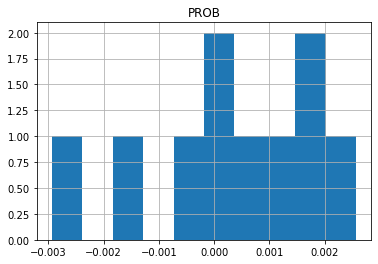

In [203]:
(temp_pos.query('t == "movement"').set_index(['t', 'fold']) - temp_neg.query('t == "movement"').set_index(['t', 'fold'])).hist()


In [248]:
df_res = pd.DataFrame([], columns=['term', 'statistic', 'pvalue', 'region', 'hemis'])

for name, id_region, hemis in regions.values:
    if id_region == 103:
        continue
        
    print(name, id_region, hemis)
    if hemis == 'r':
        hemis = 'right'
    else:
        hemis = 'left'

        
    #df_region = res2[id_region][res2[id_region].pvalue > 5e-7].sort_values(['pvalue'], ascending=True)
    df_region = res2[id_region].sort_values(['pvalue'], ascending=True)
    df_region['region'] = name
    df_region['hemis'] = hemis
    
    
    df_res = df_res.append(df_region)
    

Area TE 1.1 (HESCHL) 1 r
Area 3b (PostCG) 2 r
Area hOc4la (LOC) 3 r
Area PF (IPL) 4 r
Area hOc2 (V2, 18) 5 r
Area 6d2 (PreCG) 6 r
Area Ig3 (Insula) 7 r
Area hOc4d (Cuneus) 8 r
Area Fo4 (OFC) 9 r
Area OP4 (POperc) 10 r
Area 1 (PostCG) 11 r
Ch 4 (Basal Forebrain) 12 r
Area hPO1 (POS) 14 r
Dorsal Dentate Nucleus (Cerebellum) 15 r
Area OP2 (POperc) 16 r
Area TE 1.0 (HESCHL) 17 r
Area STS2 (STS) 18 r
Area Id3 (Insula) 19 r
Area 6mp (SMA, mesial SFG) 20 r
DG (Hippocampus) 21 r
Area PGp (IPL) 22 r
Area Ig1 (Insula) 23 r
Area 6ma (preSMA, mesial SFG) 24 r
Area TI (STG) 25 r
Area PFt (IPL) 26 r
Area p24ab (pACC) 27 r
Area p24c (pACC) 28 r
Area hOc3v (LingG) 29 r
Area TE 3 (STG) 30 r
Area PFcm (IPL) 31 r
Area 7P (SPL) 33 r
Area hIP5 (IPS) 34 r
Area 6d1 (PreCG) 35 r
Area FG1 (FusG) 36 r
Area hIP4 (IPS) 37 r
Area OP6 (Frontal Operculum) 38 r
Area FG2 (FusG) 39 r
Area hIP6 (IPS) 40 r
Area hIP3 (IPS) 41 r
Area Fo5 (OFC) 42 r
CM (Amygdala) 43 r
Area OP7 (Frontal Operculum) 44 r
Area 4p (PreCG) 45 r
A

In [219]:
df_res.to_hdf('Reverse Inference, statistic and pvalue - 10 folds.hdf', key='results')

In [243]:
df_res

,term,statistic,pvalue,region,hemis
45,listening,32.712192,5.735522e-11,Area TE 1.1 (HESCHL),right
57,multisensory,27.540132,2.661870e-10,Area TE 1.1 (HESCHL),right
59,perception,26.435942,3.831349e-10,Area TE 1.1 (HESCHL),right
46,localization,20.113933,4.317892e-09,Area TE 1.1 (HESCHL),right
34,imagery,18.349281,9.691557e-09,Area TE 1.1 (HESCHL),right
...,...,...,...,...,...
60,localization,-27.662108,1.000000e+00,Area Fo3 (OFC),left
11,categorization,-29.296032,1.000000e+00,Area Fo3 (OFC),left
76,perception,-36.019569,1.000000e+00,Area Fo3 (OFC),left
72,movement,-37.848779,1.000000e+00,Area Fo3 (OFC),left


In [135]:
res2[1079][res2[1079].pvalue < 0.05].sort_values(['pvalue'], ascending=True)

,term,statistic,pvalue
18,memory,43.575587,4.408088e-12
24,retrieval,38.330960,1.390091e-11
16,learning,24.299990,8.100435e-10
6,encoding,21.108060,2.820139e-09
23,recognition,19.576946,5.481391e-09
19,memory retrieval,18.145711,1.068945e-08
7,episodic memory,16.932803,1.960461e-08
20,navigation,11.532992,5.394928e-07
2,autobiographical memory,11.478504,5.615958e-07
8,expertise,10.458416,1.230506e-06


In [258]:
cogAt = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('CogAt'),
    [
        (
            'cogat.xml',
            'http://data.bioontology.org/ontologies/COGAT/download?'
            'apikey=8b5b7825-538d-40e0-9e9e-5ab9274a9aeb&download_format=rdf',
            {'move': 'cogat.xml'}
        )
    ]
)[0]

nl = NeurolangPDL()
nl.load_ontology(cogAt)

part_of = nl.new_symbol(name='http://www.obofoundry.org/ro/ro.owl#part_of')
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))
label = nl.new_symbol(name=str(RDFS.label))
hasTopConcept = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#hasTopConcept')

@nl.add_symbol
def word_lower(name: str) -> str:
    return name.lower()

# NeuroSynth
ns_database_fn, ns_features_fn = datasets.utils._fetch_files(
    datasets.utils._get_dataset_dir('neurosynth'),
    [
        (
            'database.txt',
            'https://github.com/neurosynth/neurosynth-data/raw/master/current_data.tar.gz',
            {'uncompress': True}
        ),
        (
            'features.txt',
            'https://github.com/neurosynth/neurosynth-data/raw/master/current_data.tar.gz',
            {'uncompress': True}
        ),
    ]
)

ns_features = pd.read_csv(ns_features_fn, sep=f'\t')
ns_terms = (
    pd.melt(
            ns_features,
            var_name='term', id_vars='pmid', value_name='TfIdf'
       )
    .query('TfIdf > 1e-3')[['pmid', 'term']]
)

terms = nl.add_tuple_set(ns_terms.values, name='terms')

with nl.scope as e:

    e.ontology_terms[e.cp, e.onto_name] = (
    hasTopConcept[e.uri, e.cp] &
    label[e.uri, e.onto_name]
    )

    e.lower_terms[e.cp, e.term] = (
        e.ontology_terms[e.cp, e.onto_term] &
        (e.term == word_lower[e.onto_term])
    )

    e.filtered_terms[e.cp, e.t] = (
        e.terms[..., e.t] &
        e.lower_terms[e.cp, e.t]
    )

    f_term = nl.solve_all()

In [266]:
df_cp = f_term['filtered_terms'].as_pandas_dataframe()[['cp', 't']]
df_cp = df_cp.drop_duplicates()

In [267]:
df_res2 = df_res.set_index('term').join(df_cp.set_index('t'))

In [268]:
df_res2 = df_res2.rename(columns={'cp': 'topConcept'})

In [276]:
df_res.to_hdf('Reverse Inference, statistic and pvalue - 10 folds.hdf', key='results')

In [269]:
df_cp

,cp,t
0,Action,action
886,Learning and Memory,adaptation
1194,,addiction
1329,,anticipation
1630,Emotion,anxiety
...,...,...
40278,Language,verbal fluency
40362,Attention,visual attention
40486,Perception,visual perception
40569,Language,word recognition


In [270]:
df_res

,term,statistic,pvalue,region,hemis
45,listening,32.712192,5.735522e-11,Area TE 1.1 (HESCHL),right
57,multisensory,27.540132,2.661870e-10,Area TE 1.1 (HESCHL),right
59,perception,26.435942,3.831349e-10,Area TE 1.1 (HESCHL),right
46,localization,20.113933,4.317892e-09,Area TE 1.1 (HESCHL),right
34,imagery,18.349281,9.691557e-09,Area TE 1.1 (HESCHL),right
...,...,...,...,...,...
60,localization,-27.662108,1.000000e+00,Area Fo3 (OFC),left
11,categorization,-29.296032,1.000000e+00,Area Fo3 (OFC),left
76,perception,-36.019569,1.000000e+00,Area Fo3 (OFC),left
72,movement,-37.848779,1.000000e+00,Area Fo3 (OFC),left


In [275]:
df_res2.head(500)

,statistic,pvalue,region,hemis,topConcept
action,-3.471670,9.964849e-01,Area TE 1.1 (HESCHL),right,Action
action,36.744746,2.028988e-11,Area 3b (PostCG),right,Action
action,29.758906,1.334512e-10,Area hOc4la (LOC),right,Action
action,30.818174,9.768348e-11,Area PF (IPL),right,Action
action,0.751389,2.358044e-01,"Area hOc2 (V2, 18)",right,Action
...,...,...,...,...,...
addiction,-22.810740,1.000000e+00,Area hIP6 (IPS),left,
addiction,-28.983141,1.000000e+00,Area hIP3 (IPS),left,
addiction,4.352043,9.223742e-04,CM (Amygdala),left,
addiction,-3.838273,9.980115e-01,Area 4p (PreCG),left,
